# Glitching an Image

Glitching can be achieved in many different ways, including by opening an image file in a text editor and making random changes to the data, or by opening an image file in something like [Audacity](https://www.audacityteam.org/) and running sound filters on the data. 

The code below is by Mathieu Guimond-Morganti, and can be found on Github [here](https://github.com/guimondmm/prism-sort-glitch). His script allows you to take an input picture file (jpg) and specify parameters by which the data in that file will be manipulated. It works by isolating rows and columns of the data and doing a broken sort of the data (see also [this](http://datamoshing.com/2016/06/16/how-to-glitch-images-using-pixel-sorting/)). 

Run the code below to see it glitch this photograph of the Euphronios Krater:

![the Euphronios Krater](pic01.jpg)

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Prism Sort glitch algorithm v0.1.3.

Copyright 2016 Mathieu Guimond-Morganti

This program is licensed under the Creative Commons Attribution-ShareAlike 4.0
International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-sa/4.0/.

Usage:  %(interpreter)s %(scriptfile)s inputfile [options]
-a, --angle=NUM     : rotates the glitch effect by this many degrees
                      (default: 0, i.e. vertical)
-b, --blocks=NUM    : number of blocks (default: 9)
                      affects the overlapping of the glitch effect
                      (higher = more intense)
-d, --dither        : makes result more noisy, and less blocky
-f, --fuzzyedges    : in combination with a rotation, will leave a fuzzy black
                      border around the image
-h, --help          : displays this help message
-H, --horizontal    : processes the image horizontally (same as -a 90)
-i, --intensity=NUM : intensity (recommended: -2~2; default: 0)
                      will not go lower than (3 - number of blocks)
-I, --interpol=NUM  : rotation interpolation (default: 0 = bicubic, sharp)
                      (1 = bilinear, smooth; 2 = nearest, aliased)
-J, --jpeg=NUM      : saves as JPEG at the specified quality
                      (recommended: 75~95)
-n, --numoutput=NUM : number of output files to be generated (default: 1)
                      the output files are in the format:
                      <originalfilename>_out<number>.<ext>
                      files are overwritten without warning!
-P, --png           : saves as PNG (default)
-r, --resize=NUM    : resize factor (e.g. 2 divides side by sqrt(2); optional)
-s, --sound         : play alert sound when done (silent by default)
-V, --vertical      : processes the image vertically (default; same as -a 0)
"""

# Images glitched using this algorithm should be licensed under CC-BY-SA 4.0
# as well, with proper attribution, as I believe they constitute
# "adapted material" as covered under the terms of the license.
# The reason for this humble request is to encourage people to further
# experiment with this algorithm or its variants, as well as remix
# other people's artwork.
#
# I don't want this project to be solely "open source";
# I want it to be "open art" as well.
# If no one credits the use of this algorithm, fewer people will use it.
# And a world without glitch art would be sad :'(
#
# Finally, if you feel generous or you want to get in touch,
# my email is guimondmm at gmail dot com


from __future__ import print_function  # prevent Python 2 crash, unsupported!
from random import random, randrange
from math import sqrt, radians as rad, cos, sin
from platform import system
import sys
import getopt
import subprocess

try:
    BOLD = "\x1B[0;1m"  # ANSI escape code for bold or bright text
    NORM = "\x1B[0m"  # ANSI escape code to reset text to normal
    # verify which version of Python is running the script
    assert(sys.version_info.major >= 3)
except AssertionError:
    print(BOLD+"\nThis script requires Python 3."+NORM)
    print("Install it (if needed), then try the command: "+BOLD,
          "py -3" if system() == "Windows" else "python3",
          __file__+NORM+"\n")
    sys.exit(69)

try:
    # check for prerequisites: Python 3.x, the Pillow module,
    # and its dependencies ($ pip3 install Pillow)
    # http://pillow.readthedocs.org/en/3.1.x/installation.html
    from PIL import Image, ImageOps
except ImportError:
    # try to install Pillow automatically
    print("\nThis Python 3 script requires the "+BOLD+"Pillow"+NORM+" module "
          "and its dependencies.\nPlease wait...", end="")
    try:
        # install is the output of the command in bytes
        install = subprocess.Popen(["pip3", "install", "Pillow"],
                                   stdout=subprocess.PIPE,
                                   stderr=subprocess.PIPE).communicate()[0]
    except FileNotFoundError as e:  # if pip3 is not in PATH
        install = bytes(str(e), "ascii")
    if b'Successfully installed' in install:
        print("\r"+BOLD+"Pillow was automatically installed."+NORM,
              "\nPlease try running the script again.\n")
    else:  # manual instructions
        print("\r"+BOLD+"You need to install Pillow manually."+NORM)
        print("Try the command: "+BOLD, "pip3 install Pillow"+NORM)
        print("or visit"+BOLD,
              "http://pillow.readthedocs.org/en/3.1.x/installation.html"
              "\n"+NORM)
    sys.exit(69)


# default parameters
IMAGE_WIDTH, IMAGE_HEIGHT = None, None  # will be initialized later
RESIZE_FACT = 1  # each dimension will be resized by sqrt(RESIZE_FACT)
BLOCKS = 9  # size of a block is each dimension of the picture divided by this
NUM_OUTPUT = 1  # how many different images to output
DITHER = False  # randomizes the glitch so it looks noisier but less blocky
INTENSITY = 0  # tweaks the probability of line corruption
ROTATION = 0  # defaults to vertical
JPEG = None  # save as .jpg if 0 < JPEG < 100
FUZZY_EDGES = False  # if True, don't crop the output as much
INTERPOLATION = 0  # for rotation; 0 = bicubic, 1 = bilinear, 2 = nearest
BELL = ''  # silent by default
L = []  # empty list


def printHelp():
    """Print the script's usage message, formatted from docstring, and exit."""
    print(__doc__ % {'interpreter': 'py -3' if system() == 'Windows'
                                    else 'python3',
                     'scriptfile': __file__})
    sys.exit(64)


def openImage(file, resize=1):
    """Open an image file, and resize it as needed.

    Args:
        file (str):  the relative path of the image
        resize (int):  a resize factor for the image's dimensions (default: 1)
    Returns:
        Image, int, int:  an Image object, its width, its height
    """
    try:
        image = Image.open("pic01.jpg")
    except FileNotFoundError:
        print("No such file: '"+file+"'. Please double-check the command-line "
              "syntax.")
        sys.exit(66)
    # because don't want to manipulate JPEGs directly:
    image = image.convert('RGB')
    if resize != 1:  # makes image smaller for speed
        image = image.resize((int(image.size[0]/sqrt(resize)),
                              int(image.size[1]/sqrt(resize))),
                             Image.LANCZOS)
    width, height = int(image.size[0]), int(image.size[1])
    return image, width, height


def probability(p):
    """Determine if a certain event occurs.

    Args:
        p (float):  the probability of that event
    Returns:
        bool.
    """
    return True if random() < p else False


def partialSort(numList):
    """Sort a list partially and randomly.

    Args:
        numList (list):  the list to sort
    Returns:
        list:  the partially sorted list
    """
    ls = list(numList)
    a = randrange(len(ls) - 1)  # lower bound
    b = randrange(a + 1, len(ls))  # upper bound
    if probability(0.5):
        if probability(0.95):
            ls = ls[0:a] + sorted(ls[a:b]) + ls[b:]  # middle
        else:
            ls = sorted(ls[0:b]) + ls[b:]  # beginning
    else:
        if probability(0.95):
            ls = ls[0:a] + list(reversed(sorted(ls[a:b]))) + ls[b:]  # middle
        else:
            ls = ls[0:a] + list(reversed(sorted(ls[a:])))  # end
    return ls


def progress(counter=0, total=None, done=False):
    """Display a rudimentary progression counter.

    Args:
        counter (int):  keeps track of progression (default: 0)
        total (int):  the maximum number of iterations (default: None)
        done (bool):  whether a task is done or not (default: False)
    """
    if done:
        print('.' * 10, "Done!", end="")
        print("" if not L
              else " \U0001F60A\x1B[0m"
              if system() == "\x44\x61\x72\x77\x69\x6E"
              else " \x3A\x29\x1B[0m")
    elif total is not None:
        print("" if not L else "\x1B["+str(31+(counter-1) % 6)+";1m", end="")
        print(counter, "/", total)  # fraction
    else:
        out = int((counter/2)/(IMAGE_WIDTH if IMAGE_WIDTH >= IMAGE_HEIGHT
                               else IMAGE_HEIGHT) * 10)
        print(out * '.' + (10 - out) * ' ', end="\r")  # animated dots


def pixSort(image, startW=0, startH=0,
            endW=IMAGE_WIDTH, endH=IMAGE_HEIGHT, p=0.8):
    """Glitch a region of an image using a purposefully broken pixel sort.

    Args:
        image (Image):  an Image object
        startW (int):  starting W-coordinate of the region (default: 0)
        startH (int):  starting H-coordinate of the region (default: 0)
        endW (int): ending W-coordinate of the region (default: IMAGE_WIDTH)
        endH (int): ending H-coordinate of the region (default: IMAGE_HEIGHT)
        p (float): the probability of a line being glitched (default: 0.8)
    Returns:
        Image: the glitched Image object
    """
    for y in range(startH, endH):  # for each line of the pic
        progress(y)
        if probability(p):
            line = []
            for x in range(startW, endW):
                try:
                    # make list of every pixel RGB value on the line as tuple
                    line.append(image.getpixel((y, x)))
                except IndexError:  # if out of bounds of the picture
                    break
            # backup of the line before sort, to unglitch a channel later
            originalLine = list(line)
            # if we broke out of the previous loop we might get out of bounds
            try:
                line = partialSort(line)
            except ValueError:
                pass  # My code is bad, and I should feel bad.
            # restore one of the original channels at random (looks colourful)
            if probability(p * 0.75):
                colour = randrange(3)  # 0 = R, 1 = G, 2 = B
                for px in range(len(line)):
                    line[px] = ((originalLine[px][0]
                                 if colour == 0 else line[px][0]),
                                (originalLine[px][1]
                                 if colour == 1 else line[px][1]),
                                (originalLine[px][2]
                                 if colour == 2 else line[px][2]))
            # make the actual changes to the image object
            for x in range(len(line)):
                try:
                    image.putpixel((y + (randrange(1, 3)
                                         if probability(0.1) and DITHER
                                         else 1),
                                    startW + x),
                                   (line[x]))
                except IndexError:  # out of bounds of the picture
                    break
    return image


def glitch(image, blocks=9, rotation=0):
    """Glitch an Image object at a specific angle and intensity.

    Args:
        image (Image): an Image object
        blocks (int): affects size/intensity of overlapping blocks (default: 9)
        rotation (int): an angle of rotation (default: 0)
    Returns:
        Image: the glitched Image object
    """
    # the script works with overlapping rectangles of the following size:
    wBlock, hBlock = int(IMAGE_WIDTH/blocks), int(IMAGE_HEIGHT/blocks)

    # rotate the picture
    if rotation != 0:
        image = image.rotate(rotation,
                             resample=(Image.BILINEAR
                                       if INTERPOLATION == 1
                                       else Image.NEAREST
                                       if INTERPOLATION == 2
                                       else Image.BICUBIC),
                             expand=True)
    if rotation == 0 or abs(rotation) == 90:  # adds a black border
        image = ImageOps.expand(image,
                                border=(wBlock if wBlock >= hBlock
                                        else hBlock),
                                fill=0)

    # glitch loop
    currentHeight = 0
    # the loops continue a bit outside the original image's bounds
    # in order to produce the distinctive "fuzzy edges" look,
    # hence the lengthy conditionals.
    while (currentHeight + hBlock * 2/3 <=
           (IMAGE_HEIGHT if IMAGE_HEIGHT >= IMAGE_WIDTH
            else IMAGE_WIDTH)*2):
        currentWidth = 0
        while (currentWidth + wBlock * 2/3 <=
               (IMAGE_WIDTH if IMAGE_WIDTH >= IMAGE_HEIGHT
                else IMAGE_HEIGHT)*2):
            image = pixSort(image,
                            currentHeight,
                            currentWidth,
                            currentHeight + hBlock,
                            currentWidth + wBlock,
                            # I pulled the following formula out of my a**,
                            # but empirically it seemed to yield the best
                            # p values for blocks between 5 and 11.
                            p=(1 - (blocks**2 / (blocks + 1)**2) **
                               randrange(blocks - 4 + INTENSITY,
                                         blocks - 1 + INTENSITY)))
            currentWidth += int(wBlock * 2/3) if blocks > 1 else wBlock
        currentHeight += int(hBlock * 2/3) if blocks > 1 else hBlock

    # undo the rotation
    if rotation != 0:
        image = image.rotate(-rotation,
                             resample=(Image.BILINEAR
                                       if INTERPOLATION == 1
                                       else Image.NEAREST
                                       if INTERPOLATION == 2
                                       else Image.BICUBIC),
                             expand=True)

    return image


def main():
    """Main loop; Open and save the picture file."""
    try:
        iteration = 0
        while iteration < NUM_OUTPUT:
            progress(iteration + 1, total=NUM_OUTPUT)

            # opening the file and glitching it
            im = openImage(FILENAME, RESIZE_FACT)[0]
            im = glitch(im, BLOCKS, ROTATION)

            # cropping the image to original size, except if fuzzy edges,
            # in which case a black border is left around the picture.
            trig = (abs(sin(rad(ROTATION)))
                    if abs(sin(rad(ROTATION))) > abs(cos(rad(ROTATION)))
                    else abs(cos(rad(ROTATION))))  # for fuzzy edges
            left = int((im.width -  # the current image width
                        IMAGE_WIDTH -  # the original image width
                        (0 if not FUZZY_EDGES
                         else IMAGE_WIDTH/BLOCKS*trig))/2)  # less crop
            top = int((im.height -
                       IMAGE_HEIGHT -
                       (0 if not FUZZY_EDGES
                        else IMAGE_HEIGHT/BLOCKS*trig))/2)
            right = int(IMAGE_WIDTH +
                        (im.width -
                         IMAGE_WIDTH +
                         (0 if not FUZZY_EDGES
                          else IMAGE_WIDTH/BLOCKS*trig))/2)
            bottom = int(IMAGE_HEIGHT +
                         (im.height -
                          IMAGE_HEIGHT +
                          (0 if not FUZZY_EDGES
                           else IMAGE_HEIGHT/BLOCKS*trig))/2)
            # Pillow uses (left, top, right, bottom) coordinates,
            # which define a rectangle region to keep.
            im = im.crop(box=(left, top, right, bottom))

            # saving the output
            if JPEG is None:
                im.save(FILENAME.split('.')[0]+'_out'+str(iteration)+".png")
            else:
                im.save(FILENAME.split('.')[0]+'_out'+str(iteration)+".jpg",
                        optimize=True,
                        quality=JPEG,
                        subsampling=0)  # see Pillow doc for jpeg options

            iteration += 1
            progress(done=True)
        print(BELL)  # blank line if silent

    except KeyboardInterrupt:
        print("\nCancelled."+NORM if not L
              else "\n\x1B[0m\U0001F308"
              if system() == "\x44\x61\x72\x77\x69\x6E"
              else "\n\x3A\x27\x28\x1B[0m")
        sys.exit(70)

# reading command-line parameters and launching the main loop
if __name__ == "__main__":
    try:
        if sys.argv[1] in ('-h', '--help'):
            printHelp()
        FILENAME = sys.argv[1]
        opts, args = getopt.getopt(sys.argv[2:],  # list of valid flags
                                   "hHVdPfsi:r:b:n:J:a:I:",
                                   ["interpol=", "fuzzyedges", "vertical",
                                    "help", "blocks=", "numoutput=", "resize=",
                                    "dither", "intensity=", "horizontal",
                                    "angle=", "jpeg=", "sound",
                                    "png", "\x67\x61\x79"])
    # IndexError if FILENAME unspecified
    except (IndexError, getopt.GetoptError):
        printHelp()
    for opt, arg in opts:
        try:
            if opt in ('-h', '--help'):  # usage message
                printHelp()
            elif opt in ('-b', '--blocks'):  # affects size & num of glitches
                BLOCKS = int(arg)
            elif opt in ('-n', '--numoutput'):  # number of files generated
                NUM_OUTPUT = int(arg)
            elif opt in ('-r', '--resize'):  # resize each side by sqrt(arg)
                RESIZE_FACT = int(arg)
            elif opt in ('-d', '--dither'):  # effect more noisy, less blocky
                DITHER = True
            elif opt in ('-i', '--intensity'):  # intensity affects probability
                INTENSITY = int(arg)
            elif opt in ('-H', '--horizontal'):  # rotate by 90 degrees
                ROTATION = 90
            elif opt in ('-V', '--vertical'):  # useless by default
                ROTATION = 0
            elif opt in ('\x2D\x2D\x67\x61\x79'):  # puts some joy in your life
                L.append('')
            elif opt in ('-J', '--jpeg'):  # output in jpeg with given quality
                JPEG = int(arg)
            elif opt in ('-P', '--png'):  # useless by default
                JPEG = None
            elif opt in ('-a', '--angle'):  # rotation by this angle
                ROTATION = int(arg)
            elif opt in ('-f', '--fuzzyedges'):  # leaves a black frame
                FUZZY_EDGES = True
            elif opt in ('-I', '--interpol'):  # resizing always uses Lanczos!
                INTERPOLATION = int(arg)
            elif opt in ('-s', '--sound'):  # ding!
                BELL = '\a'
        except ValueError:
            printHelp()
    # failsafe for intensity, otherwise yields poor results
    INTENSITY = INTENSITY if BLOCKS + INTENSITY >= 3 else 3 - BLOCKS
    IMAGE_WIDTH, IMAGE_HEIGHT = openImage(FILENAME, RESIZE_FACT)[1:]
    main()


1 / 1
.......... Done!



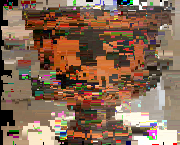

In [3]:
# let's take a look at it
from IPython.display import Image
Image(filename='-f_out0.png')

This line:

```
    try:
        image = Image.open("pic01.jpg")
```

originally read like this:

```
    try:
        image = Image.open(file)
```

In which case, this code can be its own command line program - we call it from the terminal (which we access from a notebook using `!` and we feed it the filename of the image we want to mess around with). Try it now- run the following codeblock, and then download the results to see what you've got!

In [13]:
!python prismsort.py pic01.jpg -n 5 -r 3 -a 45 -i -2 --fuzzyedges --jpeg 95

1 / 5


.......... Done!
2 / 5
.......... Done!
3 / 5
.......... Done!
4 / 5
.......... Done!
5 / 5
.......... Done!



This creates 5 randomly glitched versions of that photo that are 1/3rd the size of the original, with a diagonal pattern at a 45° angle, and a slightly reduced intensity, with fuzzy (feathered) edges, and saves them in JPEG at 95% quality.


In [ ]:
# Let's take a look at them; the filenames range from pic01_out0.jpg to pic01_out4.jpg.
# rerun or copy the line below with the different file names to display each picture
Image(filename='pic01_out0.jpg')


The parameters that you can call are:

```
-a, --angle=NUM     : rotates the glitch effect by this many degrees
                      (default: 0, i.e. vertical)
-b, --blocks=NUM    : number of blocks (default: 9)
                      affects the overlapping of the glitch effect
                      (higher = more intense)
-d, --dither        : makes result more noisy, and less blocky
-f, --fuzzyedges    : in combination with a rotation, will leave a fuzzy black
                      border around the image
-h, --help          : displays this help message
-H, --horizontal    : processes the image horizontally (same as -a 90)
-i, --intensity=NUM : intensity (recommended: -2~2; default: 0)
                      will not go lower than (3 - number of blocks)
-I, --interpol=NUM  : rotation interpolation (default: 0 = bicubic, sharp)
                      (1 = bilinear, smooth; 2 = nearest, aliased)
-J, --jpeg=NUM      : saves as JPEG at the specified quality
                      (recommended: 75~95)
-n, --numoutput=NUM : number of output files to be generated (default: 1)
                      the output files are in the format:
                      <originalfilename>_out<number>.<ext>
                      files are overwritten without warning!
-P, --png           : saves as PNG (default)
-r, --resize=NUM    : resize factor (e.g. 2 divides side by sqrt(2); optional)
-s, --sound         : play alert sound when done (silent by default)
-V, --vertical      : processes the image vertically (default; same as -a 0) 

```


Now get glitching!